In [3]:
import os, sys

import pathlib
import pandas as pd
import numpy as np
from easydict import EasyDict as edict
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time

dir_path = pathlib.Path().absolute()
file = '../data/imputed_data.csv'
data_path = os.path.join(dir_path, file)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0

df.drop(columns=['SPI_X1','SPI_Y1','SPI_X2','SPI_Y2','SPI_L1','SPI_W1','SPI_L2','SPI_W2'], inplace=True)
df.head(10)

,CRD,PartType,Orient.,X,Y,SPI_X_AVG,SPI_Y_AVG,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_VOLUME_MEAN
0,B1,R0402,90.0,31.26,100.11,-52.00,61.90,61.90,52.00,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,78.71525
1,B2,R0402,90.0,31.83,100.11,-47.00,63.70,63.70,47.00,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,77.33190
2,B3,R0402,90.0,32.40,100.11,-41.60,72.35,72.35,41.60,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,77.17380
3,B4,R0402,90.0,32.97,100.11,-50.60,63.10,63.10,50.60,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,77.96495
4,B5,R0402,90.0,33.54,100.11,-50.00,69.45,69.45,50.00,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,75.37700
5,B6,R0402,90.0,31.26,99.20,-49.10,59.75,59.75,49.10,-31.059980,1.531298,3.611,1.531298,31.059980,-5.925862,17.682121,0.000,17.682121,5.925862,CENTER,400.0,200.0,77.66230
6,B7,R0402,90.0,31.83,99.20,-44.95,60.10,60.10,44.95,-20.728939,10.258562,-3.247,10.258562,20.728939,-17.024027,33.615910,3.455,33.615910,17.024027,CENTER,400.0,200.0,77.56575
7,B8,R0402,90.0,32.40,99.20,-39.05,70.00,70.00,39.05,-27.195978,11.357373,-2.031,11.357373,27.195978,-1.401807,29.627155,3.337,29.627155,1.401807,CENTER,400.0,200.0,79.10090
8,B9,R0402,90.0,32.97,99.20,-46.55,62.45,62.45,46.55,-19.822590,1.057152,-3.047,1.057152,19.822590,-20.989681,15.195607,3.310,15.195607,20.989681,CENTER,400.0,200.0,81.96445
9,B10,R0402,90.0,33.54,99.20,-53.25,71.15,71.15,53.25,-26.842043,3.604794,-3.022,3.604794,26.842043,-17.169552,31.046926,-1.660,31.046926,17.169552,CENTER,400.0,200.0,79.36680


In [8]:
# switch 90 data to 0 data
def switchOrient(x90, y90):
    y0 = float(x90)
    x0 = float(-y90)
    return x0, y0 

In [7]:
# 전체 SPI offset 꽈 post offset의 벡터거리 차이에 대한 pre/post angle관계 

# 1. group by chip type
ABSOLUTE_ANGLE = True
BY_CHIP_PERCENTAGE = True
PRE_OR_POST_ANGLE = 'pre'
DISTANCE = 'spi' # [DISTANCE] - POST 
STOP_AFTER = 10 # rows

dfgroups = df.groupby(['PartType']) 
# df_chips :: holds dataframes [diff_distance, angle]
df_chips = edict()
# df_chips_condition :: holds dataframes by condition (2)
#   (0: condition 1 [SPI<=CHIP]
#    1: condition 2 [SPI>CHIP])
df_chips_condition = edict()
# df_chips_cond_quad :: holds dataframes by quadrant condition (4) for SPI and Chip (<= or >) (2) -> (8 total)
df_chips_cond_quad = edict()
# df_chips_condition2 :: holds dataframes by the following conditions
#   (0: SPI (+,+) and chip (+,+) and SPI <= chip, 
#    1: SPI (+,+) and chip (-,-) and SPI <= chip, 
#    2: SPI (+,+) and chip (-,-) and SPI > chip, 
#    3: SPI (-,+) and chip (-.+) and SPI <= chip, 
#    4: SPI (-,+) and chip (+,+) and SPI <= chip, 
#    5: SPI (-,+) and chip (-,-) and SPI > chip, 
df_chips_condition2 = edict() # Chip이 SPI 와 동일한 뱡향으로 이동한경우, 반대방향으로 이동한경우 (6)


In [4]:

start = time.time()

for _, (chiptype, group) in enumerate(dfgroups):
    print(chiptype,'...')
    time.sleep(0.3)
    
    if ABSOLUTE_ANGLE == True:
        group['PRE_A'] = group['PRE_A'].abs()
        group['POST_A'] = group['POST_A'].abs()
    
    # initialize dictionaries of each size
    df_chips[f'{chiptype}'] = pd.DataFrame(columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    df_chips_condition[f'{chiptype}'] = \
            [pd.DataFrame(columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post']) for i in range(2)]
    df_chips_cond_quad[f'{chiptype}'] = \
            [pd.DataFrame(columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post']) for i in range(8)]
    df_chips_condition2[f'{chiptype}'] = \
            [pd.DataFrame(columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post']) for i in range(6)]
    
    chiplength = group['Chip_L'].values[0]
    
    # iterate through each row and compute offset distance difference
    t = tqdm(group.iterrows(), total=len(group))
    for idx, row in t:
        t.set_description(f'Row: {idx}')
        
        spi_x_avg, spi_y_avg = row[['SPI_X_AVG','SPI_Y_AVG']]
        pad_center_x, pad_center_y = row[['X','Y']] * 1000 # mm --> um change of units
        spi_volume_mean = row['SPI_VOLUME_MEAN']
        pre_x, pre_y = row[['PRE_X','PRE_Y']]
        post_x, post_y = row[['POST_X','POST_Y']]
        pre_angle, post_angle = row[['PRE_A','POST_A']]
        orientation = row['Orient.']
        
        ''' rotate 90 to 0 '''
        if orientation == 90:
            spi_x_avg, spi_y_avg = switchOrient(spi_x_avg, spi_y_avg)
            pad_center_x, pad_center_y = switchOrient(pad_center_x, pad_center_y)
            pre_x, pre_y = switchOrient(pre_x, pre_y)
            post_x, post_y = switchOrient(pre_x, pre_y)
        
        ''' compute vector norms for comparison '''
        spi_norm = np.linalg.norm((spi_x_avg, spi_y_avg))
        post_norm = np.linalg.norm((post_x, post_y))
        
        ''' 
        compute distance between two offset vectors from the origin (칩의 좌측하단)
        and append to df_temp dataframe
        '''
        # vector offset distance difference from SPI
        xval, yval = 0, 0
        if DISTANCE == 'spi':
            xval = spi_x_avg - post_x
            yval = spi_y_avg - post_y
        # elif DISTANCE == 'pad':
        #     xval = pad_center_x - post_x
        #     yval = pad_center_y - post_y
        diff_distance = np.linalg.norm((xval, yval))
        
        if BY_CHIP_PERCENTAGE == True:
            diff_distance = diff_distance / chiplength * 100
        
        angle = -1
        if PRE_OR_POST_ANGLE == 'pre':
            angle = pre_angle
        elif PRE_OR_POST_ANGLE == 'post':
            angle = post_angle
        
        # vector offset difference from PRE
        dist_pre = np.linalg.norm((pre_x, pre_y))
        dist_post = np.linalg.norm((post_x, post_y))
        
        # value to add
        values_to_add = [diff_distance, angle, dist_pre, dist_post]
        
        ''' append distance and angle (all) '''
        df_chips[f'{chiptype}'].loc[len(df_chips[f'{chiptype}']),:] = values_to_add
        
        ''' append distance and angle by condition only '''
        if spi_norm <= post_norm:
            df_chips_condition[f'{chiptype}'][0].loc[len(df_chips_condition[f'{chiptype}'][0]),:] = \
                values_to_add
        else:
            df_chips_condition[f'{chiptype}'][1].loc[len(df_chips_condition[f'{chiptype}'][1]),:] = \
                values_to_add
        
        ''' append distance and angle by condition and quadrant for SPI and Post (Chip) '''
        # df_chips_cond_quad
        case = -1
        # case 1: SPI offset is (+, +), Post offset is (+,+), SPI offset <= Post offset
        if spi_x_avg >= 0 and spi_y_avg >= 0 and post_x >= 0 and post_y >= 0 \
            and spi_norm <= post_norm:
            case = 0
        # case 2: SPI offset is (+, +), Post offset is (+,+), SPI offset > Post offset
        elif spi_x_avg >= 0 and spi_y_avg >= 0 and post_x >= 0 and post_y >= 0 \
            and spi_norm > post_norm:
            case = 1
        # case 3: SPI offset is (-, +), Post offset is (-,+), SPI offset <= Post offset
        elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
            and spi_norm <= post_norm:
            case = 2
        # case 4: SPI offset is (-, +), Post offset is (-,+), SPI offset  > Post offset
        elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
            and spi_norm > post_norm:
            case = 3
        # case 5: SPI offset is (-, -), Post offset is (-, -), SPI offset <= Post offset
        elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
            and spi_norm <= post_norm:
            case = 4
        # case 6: SPI offset is (-, -), Post offset is (-, -), SPI offset > Post offset
        elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
            and spi_norm > post_norm:
            case = 5
        # case 7: SPI offset is (+, -), Post offset is (+,-), SPI offset <= Post offset
        elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
            and spi_norm <= post_norm:
            case = 6
        # case 8: SPI offset is (+, -), Post offset is (+,-), SPI offset > Post offset
        elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
            and spi_norm > post_norm:
            case = 7
        df_chips_cond_quad[f'{chiptype}'][case].loc[len(df_chips_cond_quad[f'{chiptype}'][case]),:] = \
            values_to_add
        
        ''' append distance and angle by alignment direction for SPI and Post (Chip) '''
        # df_chips_condition2
        # case 1: SPI offset is (+, +), Post offset is (+,+), SPI offset <= Post offset
        if spi_x_avg >= 0 and spi_y_avg > 0 and post_x >= 0 and post_y >= 0 \
            and spi_norm <= post_norm:
            case = 0
        # case 2a: SPI offset is (-, -), Post offset is (-, -), SPI offset <= Post offset
        elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
            and spi_norm <= post_norm:
            case = 1
        # case 2b: SPI offset is (-, -), Post offset is (-, -), SPI offset > Post offset
        elif spi_x_avg <= 0 and spi_y_avg <= 0 and post_x <= 0 and post_y <= 0 \
            and spi_norm > post_norm:
            case = 2  
        # case 3: SPI offset is (-, +), Post offset is (-,+), SPI offset <= Post offset      
        elif spi_x_avg <= 0 and spi_y_avg >= 0 and post_x <= 0 and post_y >= 0 \
            and spi_norm <= post_norm:
            case = 3
        # case 4a: SPI offset is (+, -), Post offset is (+,-), SPI offset <= Post offset
        elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
            and spi_norm <= post_norm:
            case = 4
        # case 4b: SPI offset is (+, -), Post offset is (+,-), SPI offset > Post offset
        elif spi_x_avg >= 0 and spi_y_avg <= 0 and post_x >= 0 and post_y <= 0 \
            and spi_norm > post_norm:
            case = 5
        df_chips_condition2[f'{chiptype}'][case].loc[len(df_chips_condition2[f'{chiptype}'][case]),:] = \
            values_to_add
            
        # if idx > 1000: #STOP_AFTER:
        #     break
    
    # sort by distance
    tmp = df_chips[f'{chiptype}'].to_numpy()
    df_chips[f'{chiptype}'] = tmp[tmp[:,0].argsort()]    
    
    tcondition = trange(2)
    for condition in tcondition:
        tcondition.set_description('sorting condition dataframes by distance SPI:')
        tmp = df_chips_condition[f'{chiptype}'][condition].to_numpy()
        df_chips_condition[f'{chiptype}'][condition] = tmp[tmp[:,0].argsort()]    
        
    tcondition = trange(6)
    for condition in tcondition:
        tcondition.set_description('sorting condition 2 dataframes by distance SPI:')
        tmp = df_chips_condition2[f'{chiptype}'][condition].to_numpy()
        df_chips_condition2[f'{chiptype}'][condition] = tmp[tmp[:,0].argsort()]    
    
    tcase = trange(8)
    for case in tcase:
        tcase.set_description('sorting case dataframes by distance SPI:')
        tmp = df_chips_cond_quad[f'{chiptype}'][case].to_numpy()
        df_chips_cond_quad[f'{chiptype}'][case] = tmp[tmp[:,0].argsort()]    
    
print(f'It took {time.time() - start} seconds')

R0402 ...


sorting case dataframes by distance SPI:: 100%|██████████| 8/8 [00:00<00:00, 123.72it/s]


R0603 ...


sorting case dataframes by distance SPI:: 100%|██████████| 8/8 [00:00<00:00, 130.23it/s]


R1005 ...


sorting case dataframes by distance SPI:: 100%|██████████| 8/8 [00:00<00:00, 114.41it/s]

It took 2085.08926320076 seconds


In [4]:
img_path = 'spi_dist_diff_vs_pre_angle'
if not os.path.exists(img_path):
    os.makedirs(img_path)

In [21]:
# save files as pickle formats

import pickle5 as pickle
with open(f'{img_path}/df_chips.p', 'wb') as fp:
    pickle.dump(df_chips, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/df_chips_condition.p', 'wb') as fp:
    pickle.dump(df_chips_condition, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/df_chips_condition2.p', 'wb') as fp:
    pickle.dump(df_chips_condition2, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/df_chips_cond_quad.p', 'wb') as fp:
    pickle.dump(df_chips_cond_quad, fp, protocol=pickle.HIGHEST_PROTOCOL)

# JSON
# import json
# with open('data.json', 'w') as fp:
#     json.dump(data, fp)
# with open('data.json', 'r') as fp:
#     data = json.load(fp)

In [10]:
# load pickle
import pickle5 as pickle
with open(f'{img_path}/df_chips.p', 'rb') as fp:
    df_chips = pickle.load(fp)
with open(f'{img_path}/df_chips_condition.p', 'rb') as fp:
    df_chips_condition = pickle.load(fp)
with open(f'{img_path}/df_chips_condition2.p', 'rb') as fp:
    df_chips_condition2 = pickle.load(fp)
with open(f'{img_path}/df_chips_cond_quad.p', 'rb') as fp:
    df_chips_cond_quad = pickle.load(fp)


In [12]:

chips = ['R0402','R0603','R1005']
for chip in chips:
    df_chips[chip] = pd.DataFrame(df_chips[chip],dtype=float,columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    for condition1 in range(2):
        df_chips_condition[chip][condition1] = pd.DataFrame(df_chips_condition[chip][condition1], dtype=float, columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    for condition2 in range(6):
        df_chips_condition2[chip][condition2] = pd.DataFrame(df_chips_condition2[chip][condition2], dtype=float, columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    for case in range(8):
        df_chips_cond_quad[chip][case] = pd.DataFrame(df_chips_cond_quad[chip][case], dtype=float, columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])



In [13]:
# visualize
chiplengths = edict()
for _, (chiptype, group) in enumerate(dfgroups):
    chiplengths[chiptype] = group['Chip_L'].values[0]

chips = ['R0402', 'R0603', 'R1005']
for chip in chips:
    print(chip)
    for case in range(8):
        print(f"case {case}: {len(df_chips_cond_quad[chip][case])}")
        df_chips_cond_quad[chip][case] = pd.DataFrame(df_chips_cond_quad[chip][case], 
                                                      columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    print()   
    for condition in range(2):
        print(f"condition {condition}: {len(df_chips_condition[chip][condition])}")
        df_chips_condition[chip][condition] = pd.DataFrame(df_chips_condition[chip][condition], 
                                                           columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    print()   
    for condition in range(6):
        print(f"condition2 {condition}: {len(df_chips_condition2[chip][condition])}")
        df_chips_condition2[chip][condition] = pd.DataFrame(df_chips_condition2[chip][condition], 
                                                           columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    print()
    print(f"Total: {len(df_chips[chip])}")
    df_chips[chip] = pd.DataFrame(df_chips[chip], columns=['dist_SPI',f'{PRE_OR_POST_ANGLE}_angle','dist_pre','dist_post'])
    if BY_CHIP_PERCENTAGE == True:
        df_chips[chip]['dist_SPI'] /= chiplengths[chip]
        df_chips[chip]['dist_SPI'] *= 100
    print('='*67)

R0402
case 0: 1398
case 1: 7286
case 2: 398
case 3: 5317
case 4: 545
case 5: 3057
case 6: 1581
case 7: 41168

condition 0: 14793
condition 1: 45957

condition2 0: 1398
condition2 1: 7831
condition2 2: 3057
condition2 3: 5715
condition2 4: 1581
condition2 5: 41168

Total: 60750
R0603
case 0: 853
case 1: 4177
case 2: 553
case 3: 5576
case 4: 1015
case 5: 4021
case 6: 1445
case 7: 43110

condition 0: 15469
condition 1: 45281

condition2 0: 853
condition2 1: 5192
condition2 2: 4021
condition2 3: 6129
condition2 4: 1445
condition2 5: 43110

Total: 60750
R1005
case 0: 952
case 1: 6603
case 2: 803
case 3: 7031
case 4: 1037
case 5: 4205
case 6: 886
case 7: 39233

condition 0: 13948
condition 1: 46802

condition2 0: 952
condition2 1: 7640
condition2 2: 4205
condition2 3: 7834
condition2 4: 886
condition2 5: 39233

Total: 60750


In [27]:
# check values
chip = 'R0402'
condition = 0
case = 0
df_chips_cond_quad[chip][case].astype(float).describe()

,dist_SPI,pre_angle,dist_pre,dist_post
count,1398.000000,1398.000000,1398.000000,1398.000000
mean,7.925336,1.680706,56.299577,52.056255
std,5.277581,1.515669,19.189428,20.601458
min,0.134384,0.000000,10.423906,4.637021
25%,3.790729,0.000000,42.620293,37.166021
50%,6.735288,1.539500,54.933813,50.722919
75%,11.306728,3.278000,69.211330,66.654800
max,30.595044,22.381001,136.464221,136.464221


In [14]:
img_path = './spi_dist_diff_vs_pre_angle'
if not os.path.exists(img_path):
    os.makedirs(img_path)


In [21]:
''' quadrant '''
# split into distance groups (15) and compute mean and variance
chips = ['R0402', 'R0603', 'R1005']
cases = range(8)

stat_data = edict()
post_pre = edict()
for chip in chips:
    stat_data[chip] = edict()
    post_pre[chip] = edict()
    for case in cases:
        
        data = df_chips_cond_quad[chip][case].astype(float).copy()
        post_pre[chip][str(case)] = pd.DataFrame(data.iloc[:, 2:4], columns=['dist_pre','dist_post'])
        
        num_groups = 15
        data_range = data.iloc[:,0].max() - data.iloc[:,0].min()
        data_max_dists = [i * data_range / num_groups for i in np.arange(num_groups)]
        stat_data[chip][str(case)] = pd.DataFrame(columns=['dist_mean', 'angle_mean', 'angle_stddev'])
        for i, (data_max) in enumerate(data_max_dists[1:]):
            curr_i, next_i = i, i+1
            if next_i == num_groups:
                next_i = num_groups-1
            current_distances = data.iloc[:,0]
            data_valid_df = current_distances[(current_distances < data_max_dists[next_i]) & (current_distances > data_max_dists[curr_i])]
            data_valid_idx = data_valid_df.index
            data_group_df = data.iloc[data_valid_idx, :]

            if len(data_valid_idx) == 0 and curr_i != next_i:
                print('[INFO] at i:',i+1, '\t (',data_max_dists[curr_i],':',data_max_dists[next_i],'):', 'None')
                continue
            else:
                angle_mean = np.mean(data_group_df.iloc[:, 1])
                angle_stddev = np.std(data_group_df.iloc[:, 1])
                dist_median = np.mean([data_group_df.iloc[:,0].max(), data_group_df.iloc[:,0].min()])        
                if np.isnan(angle_mean) or np.isnan(angle_stddev) or np.isnan(dist_median):
                    angle_mean, angle_stddev, dist_median = 0, 0, 0
#                     print(f'>> at offset distance difference {data_max}: empty (no sample)')
            stat_data[chip][str(case)].loc[len(stat_data[chip][str(case)]),:] = [dist_median, angle_mean, angle_stddev]
# print(chip, case, '\n', stat_data, end='\n\n')

[INFO] at i: 11 	 ( 17.129515630406058 : 18.842467193446666 ): None
[INFO] at i: 13 	 ( 20.55541875648727 : 22.26837031952788 ): None
[INFO] at i: 14 	 ( 22.26837031952788 : 23.98132188256848 ): None
[INFO] at i: 14 	 ( 20.14246506513799 : 21.691885454763995 ): None


In [22]:
# visualize angle vs dist
colordict = ['r','b']

for j, chip in enumerate(chips):
    fig = plt.figure(figsize=(15,20))
    for i, case in enumerate(cases):
        ax = fig.add_subplot(len(cases)/2, 2, i+1)
        stat_data[chip][str(case)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_mean', color=colordict[0], label=f'{chip}_mean')
        stat_data[chip][str(case)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_stddev', color=colordict[1], label=f'{chip}_stddev')
        lower = [(m-s) for m,s in zip(stat_data[chip][str(case)].iloc[:,1], stat_data[chip][str(case)].iloc[:,2])]
        upper = [(m+s) for m,s in zip(stat_data[chip][str(case)].iloc[:,1], stat_data[chip][str(case)].iloc[:,2])]
        ax.fill_between(stat_data[chip][str(case)].iloc[:,0].astype(float), lower, upper, facecolor='green', alpha=0.2)
        
        ax.set_title(f'{chip}: {PRE_OR_POST_ANGLE} Angle vs. SPI-Post-AOI offset distance (case:{case+1})')
        if ABSOLUTE_ANGLE == True:
            ax.set_xlabel('SPI-Post-AOI offset distance in percentage of chip length (%)')
        else:
            ax.set_xlabel('SPI-Post-AOI offset distance (\u03BCm)')
        ax.set_ylabel(f'{PRE_OR_POST_ANGLE} angle (degree)')
        ax.set_xlim([0, 70])
        ax.set_ylim([0, 5])
        ax.legend()
        ax.grid()
        
    fig.tight_layout()
    fig.savefig(f'{img_path}/{chip}_case1.png')
    fig.clf()



/home/jongoh/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

In [23]:
# split into distance groups (15) and compute mean and variance
chips = ['R0402', 'R0603', 'R1005']
conditions = range(2)

stat_data = edict()
post_pre = edict()
for chip in chips:
    stat_data[chip] = edict()
    post_pre[chip] = edict()
    for condition in conditions:        
        data = df_chips_condition[chip][condition].astype(float).copy()
        post_pre[chip][str(case)] = pd.DataFrame(data.iloc[:, 2:4], columns=['dist_pre','dist_post'])
        
        num_groups = 15
        data_range = data.iloc[:,0].max() - data.iloc[:,0].min()
        data_max_dists = [i * data_range / num_groups for i in np.arange(num_groups)]
        stat_data[chip][str(condition)] = pd.DataFrame(columns=['dist_mean', 'angle_mean', 'angle_stddev'])
        for i, (data_max) in enumerate(data_max_dists[1:]):
            curr_i, next_i = i, i+1
            if next_i == num_groups:
                next_i = num_groups-1
            current_distances = data.iloc[:,0]
            data_valid_df = current_distances[(current_distances < data_max_dists[next_i]) & (current_distances > data_max_dists[curr_i])]
            data_valid_idx = data_valid_df.index
            data_group_df = data.iloc[data_valid_idx, :]

            if len(data_valid_idx) == 0 and curr_i != next_i:
                print('[INFO] at i:',i+1, '\t (',data_max_dists[curr_i],':',data_max_dists[next_i],'):', 'None')
                continue
            else:
                angle_mean = np.mean(data_group_df.iloc[:, 1])
                angle_stddev = np.std(data_group_df.iloc[:, 1])
                dist_median = np.mean([data_group_df.iloc[:,0].max(), data_group_df.iloc[:,0].min()])        
                if np.isnan(angle_mean) or np.isnan(angle_stddev) or np.isnan(dist_median):
                    angle_mean, angle_stddev, dist_median = 0, 0, 0
            stat_data[chip][str(condition)].loc[len(stat_data[chip][str(condition)]),:] = [dist_median, angle_mean, angle_stddev]
# print(chip, case, '\n', stat_data, end='\n\n')

In [24]:
# visualize angle vs dist
colordict = ['r','b']
for j, chip in enumerate(chips):
    fig = plt.figure(figsize=(15,5))
    for i, condition in enumerate(conditions):
        ax = fig.add_subplot(1,len(conditions),i+1)
        stat_data[chip][str(condition)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_mean', color=colordict[0], label=f'{chip}_mean')
        stat_data[chip][str(condition)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_stddev', color=colordict[1], label=f'{chip}_stddev')

        lower = [(m-s) for m,s in zip(stat_data[chip][str(condition)].iloc[:,1], stat_data[chip][str(condition)].iloc[:,2])]
        upper = [(m+s) for m,s in zip(stat_data[chip][str(condition)].iloc[:,1], stat_data[chip][str(condition)].iloc[:,2])]
        ax.fill_between(stat_data[chip][str(condition)].iloc[:,0].astype(float), lower, upper, facecolor='green', alpha=0.2)
        
        ax.set_title(f'{chip}: {PRE_OR_POST_ANGLE} Angle vs. SPI-Post-AOI offset distance (condition:{condition+1})')
        if ABSOLUTE_ANGLE == True:
            ax.set_xlabel('SPI-Post-AOI offset distance in percentage of chip length (%)')
        else:
            ax.set_xlabel('SPI-Post-AOI offset distance (\u03BCm)')
        ax.set_ylabel(f'{PRE_OR_POST_ANGLE} angle (degree)')
        ax.set_xlim([0, 70])
        ax.set_ylim([0, 6])
        ax.legend()
        ax.grid()
        
    fig.tight_layout()
    fig.savefig(f'{img_path}/{chip}_conditions3.png')
    fig.clf()


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [25]:
# split into distance groups (15) and compute mean and variance
chips = ['R0402', 'R0603', 'R1005']
conditions2 = range(6)

stat_data = edict()
for chip in chips:
    stat_data[chip] = edict()
    post_pre[chip] = edict()
    for condition in conditions2:        
        data = df_chips_condition2[chip][condition].astype(float).copy()
        
        num_groups = 15
        data_range = data.iloc[:,0].max() - data.iloc[:,0].min()
        data_max_dists = [i * data_range / num_groups for i in np.arange(num_groups)]
        stat_data[chip][str(condition)] = pd.DataFrame(columns=['dist_mean', 'angle_mean', 'angle_stddev'])
        for i, (data_max) in enumerate(data_max_dists[1:]):
            curr_i, next_i = i, i+1
            if next_i == num_groups:
                next_i = num_groups-1
            current_distances = data.iloc[:,0]
            data_valid_df = current_distances[(current_distances < data_max_dists[next_i]) & (current_distances > data_max_dists[curr_i])]
            data_valid_idx = data_valid_df.index
            data_group_df = data.iloc[data_valid_idx, :]
            
            if len(data_valid_idx) == 0 and curr_i != next_i:
                print('[INFO] at i:',i+1, '\t (',data_max_dists[curr_i],':',data_max_dists[next_i],'):', 'None')
                continue
            else:
                angle_mean = np.mean(data_group_df.iloc[:, 1])
                angle_stddev = np.std(data_group_df.iloc[:, 1])
                dist_median = np.mean([data_group_df.iloc[:,0].max(), data_group_df.iloc[:,0].min()])        
                if np.isnan(angle_mean) or np.isnan(angle_stddev) or np.isnan(dist_median):
                    angle_mean, angle_stddev, dist_median = 0, 0, 0
            stat_data[chip][str(condition)].loc[len(stat_data[chip][str(condition)]),:] = [dist_median, angle_mean, angle_stddev]


/home/jongoh/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


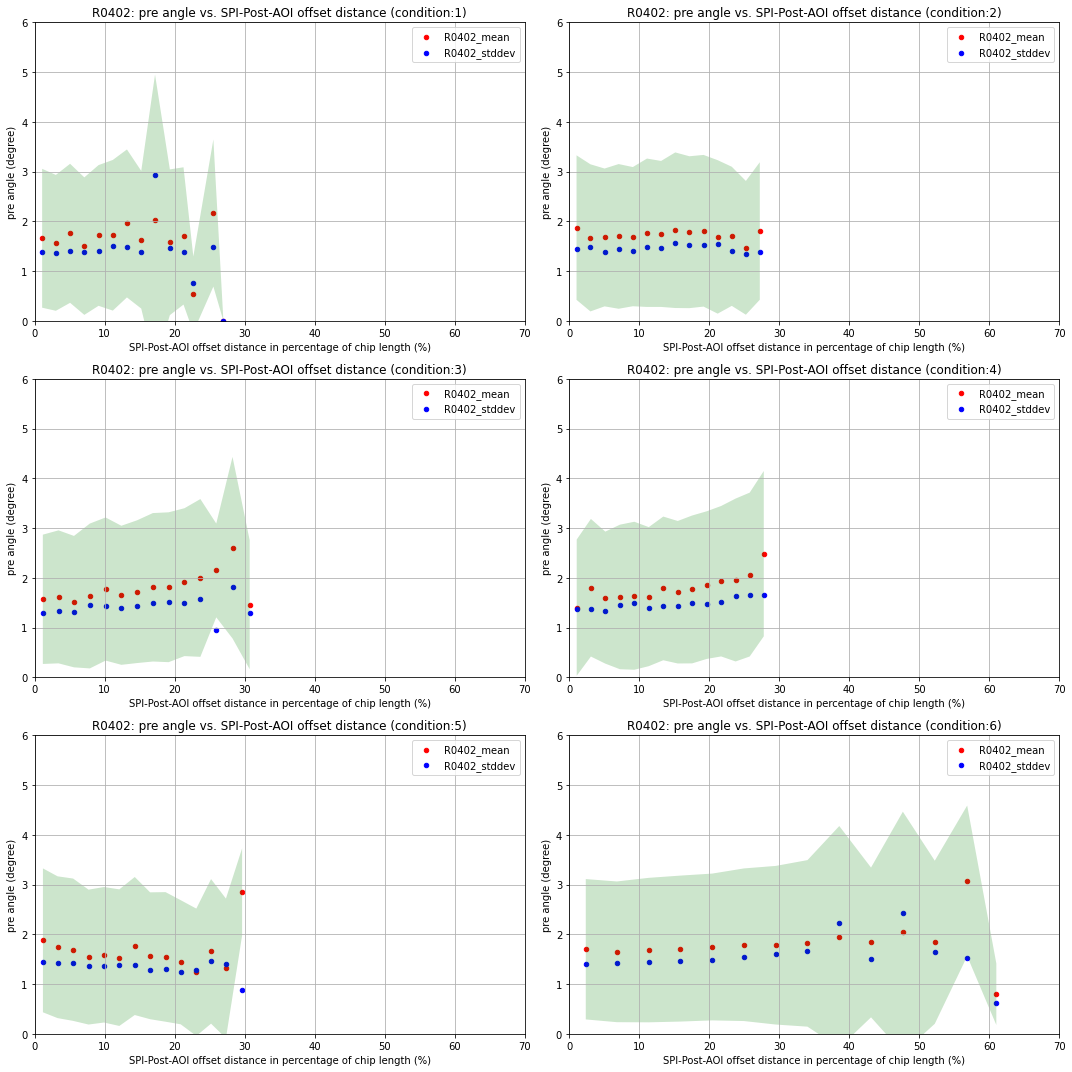

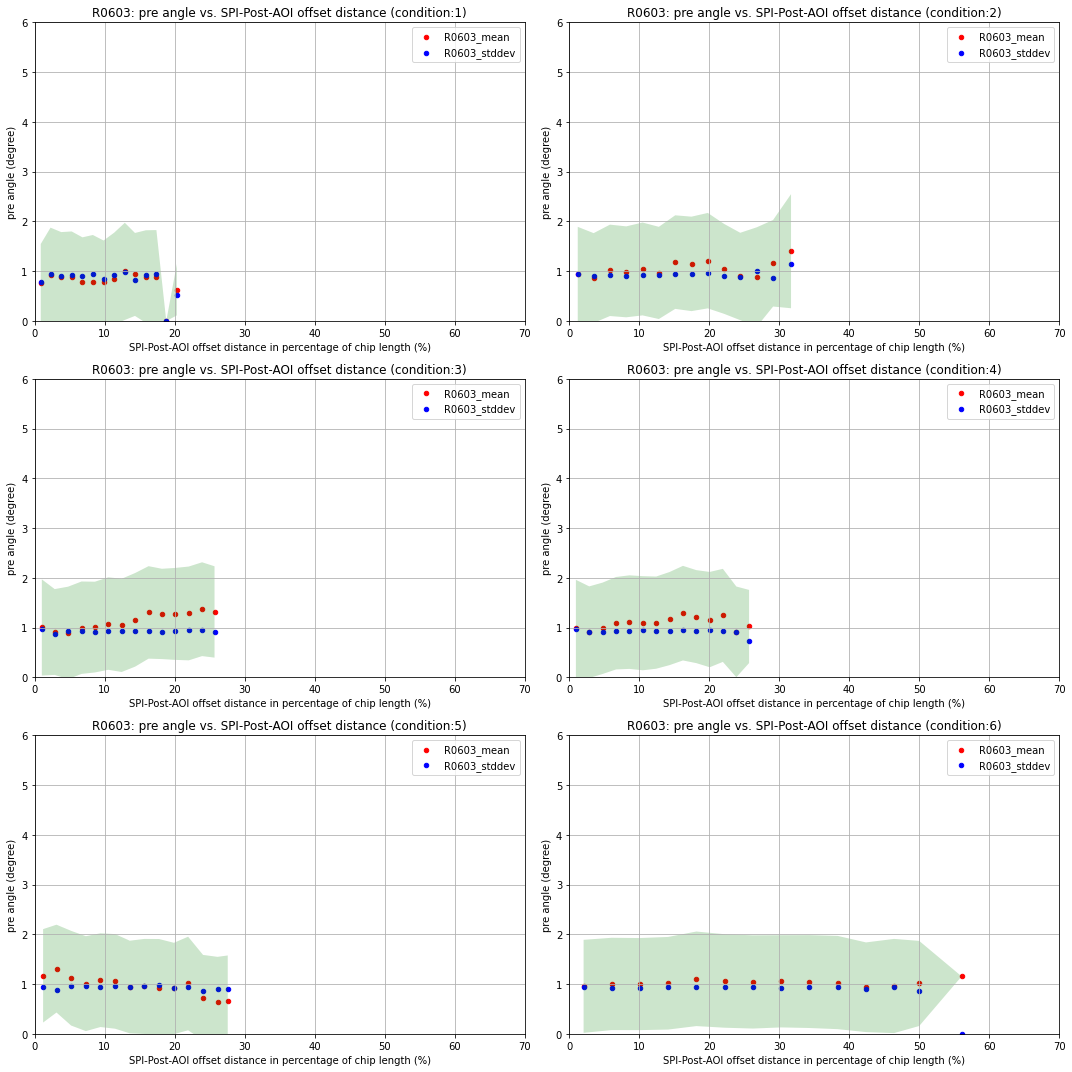

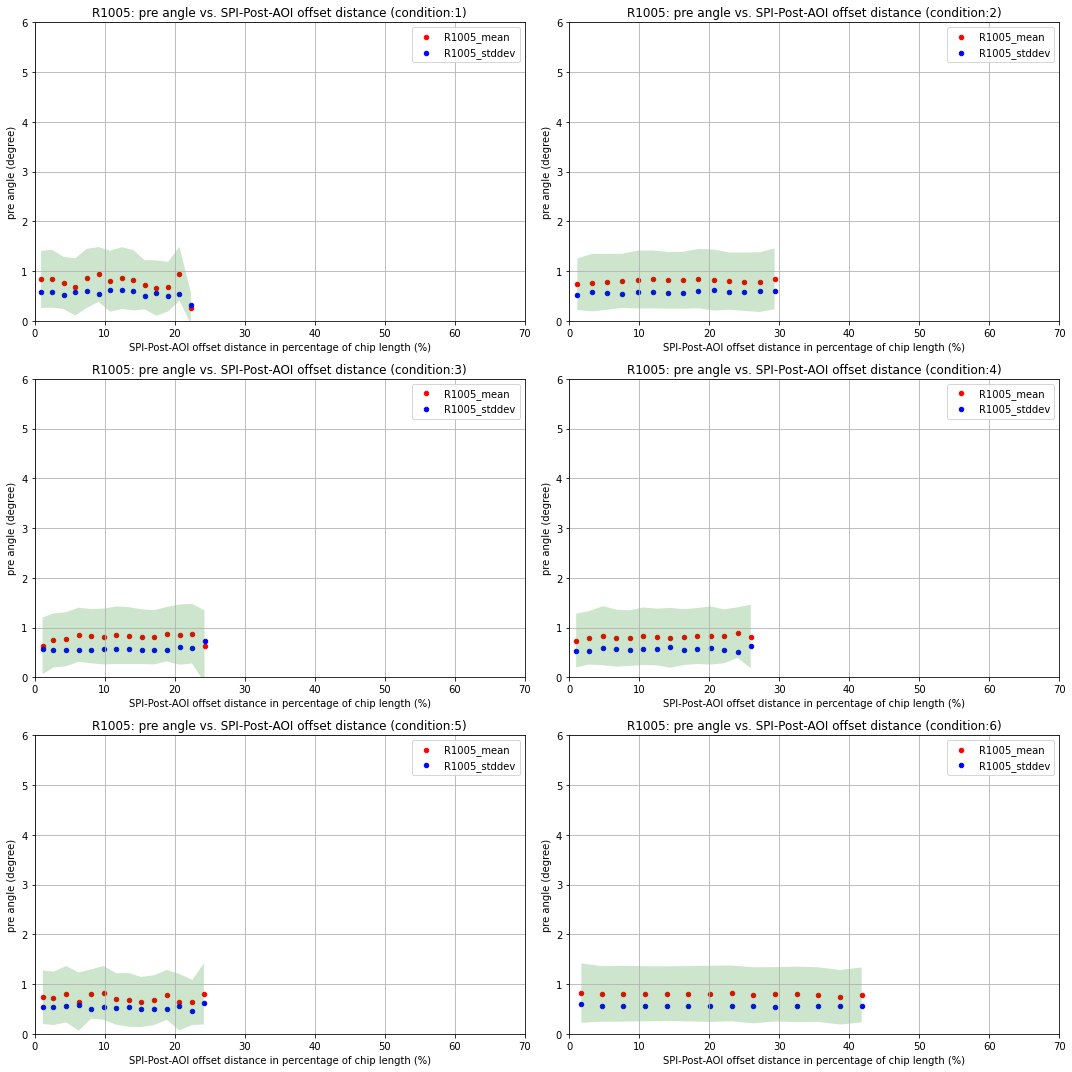

In [26]:
# visualize angle vs dist
colordict = ['r','b']
for j, chip in enumerate(chips):
    fig = plt.figure(figsize=(15,15))
    for i, condition in enumerate(conditions2):
        ax = fig.add_subplot(len(conditions2)/2, 2,i+1)
        stat_data[chip][str(condition)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_mean', color=colordict[0], label=f'{chip}_mean')
        stat_data[chip][str(condition)].plot(ax=ax, kind='scatter',x='dist_mean', y='angle_stddev', color=colordict[1], label=f'{chip}_stddev')

        lower = [(m-s) for m,s in zip(stat_data[chip][str(condition)].iloc[:,1], stat_data[chip][str(condition)].iloc[:,2])]
        upper = [(m+s) for m,s in zip(stat_data[chip][str(condition)].iloc[:,1], stat_data[chip][str(condition)].iloc[:,2])]
        ax.fill_between(stat_data[chip][str(condition)].iloc[:,0].astype(float), lower, upper, facecolor='green', alpha=0.2)
        
        ax.set_title(f'{chip}: {PRE_OR_POST_ANGLE} angle vs. SPI-Post-AOI offset distance (condition:{condition+1})')
        if ABSOLUTE_ANGLE == True:
            ax.set_xlabel('SPI-Post-AOI offset distance in percentage of chip length (%)')
        else:
            ax.set_xlabel('SPI-Post-AOI offset distance (\u03BCm)')
        ax.set_ylabel(f'{PRE_OR_POST_ANGLE} angle (degree)')
        ax.set_xlim([0, 70])
        ax.set_ylim([0, 6])
        ax.legend()
        ax.grid()

    fig.tight_layout()
    fig.savefig(f'{img_path}/{chip}_conditions2.png')
    
    fig.clf()
# plt.show()